In [23]:
import pandas as pd # pandas library use for data analysis
#first manually convert xls to csv
data = pd.read_csv("Folds_test.csv") # import csv file as dataframe

In [24]:
data

,AT,V,AP,RH,PE
0,23.64,58.49,1011.40,74.20,445.75
1,29.74,56.90,1007.15,41.91,438.76
2,19.07,49.69,1007.22,76.79,453.09
3,11.80,40.66,1017.13,97.20,464.43
4,13.97,39.16,1016.05,84.60,470.96
...,...,...,...,...,...
9562,15.12,48.92,1011.80,72.93,462.59
9563,33.41,77.95,1010.30,59.72,432.90
9564,15.99,43.34,1014.20,78.66,465.96
9565,17.65,59.87,1018.58,94.65,450.93


In [25]:
import numpy as np # numpy is library use for matrix manipulation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps): 
    X, y = list(), list() # initilize list for feature matrixs and labels
    for i in range(len(sequence)): # loop through number of sequence 
        end_ix = i + n_steps # initilize end value  
        if end_ix > len(sequence)-1: # check if end value is greater than length of sequence 
            break # use break to termninate the loop
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # seperate features and labels
        X.append(seq_x) # save feature in X list
        y.append(seq_y) # save label in Y lisr
    return np.array(X), np.array(y) # return X and Y

In [26]:
x1= np.array(data['AT'].values)  # save values of AT column in x1
x2= np.array(data['V'].values)  # save values of V column in x2
x3= np.array(data['AP'].values)  # save values of AP column in x3
x4= np.array(data['RH'].values)  # save values of RH column in x4
x5= np.array(data['PE'].values) # save values of PE column in x5

In [27]:
seq_len=4
x_1, y_1 = split_sequence(x1, seq_len) # call split sequence function 
x_2, y_2 = split_sequence(x2, seq_len) # call split sequence function 
x_3, y_3 = split_sequence(x3, seq_len) # call split sequence function 
x_4, y_4 = split_sequence(x4, seq_len) # call split sequence function 
x_5, y_5 = split_sequence(x5, seq_len) # call split sequence function 

In [28]:
from numpy import hstack # use hstack to merger different columns
X = hstack((x_1, x_2,x_3,x_4,x_5)) # merger 5 featuers into one matrix X 

In [29]:
y_1 = y_1.reshape((-1, 1)) # convert vector row to vector column matrix
y_2 = y_2.reshape((-1, 1)) # convert vector row to vector column matrix
y_3 = y_3.reshape((-1, 1)) # convert vector row to vector column matrix
y_4 = y_4.reshape((-1, 1)) # convert vector row to vector column matrix
y_5 = y_5.reshape((-1, 1)) # convert vector row to vector column matrix

In [30]:
Y = np.column_stack((y_1,y_2,y_3,y_4,y_5)) # use column wise merge to 5 labels matrix into Y

In [31]:
print(X.shape) # 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y)

(9563, 20)


In [38]:
from tensorflow.keras.models import Sequential # import keras sequential library
from tensorflow.keras.layers import Dense, LSTM,Dropout # import keras dense and lstm layers
from sklearn.model_selection import train_test_split # import train and test library
from sklearn.metrics import mean_squared_error # import metrics
import matplotlib.pyplot as plt # for visualization purpose

x = X.reshape(X.shape[0], X.shape[1], 1) # As lstm need three dimensions, so add one extra dimension
print("x:", x.shape, "y:", Y.shape) # print shape
 
in_dim = (x.shape[1], x.shape[2]) # save in input dimension
out_dim = Y.shape[1] # save in out_dim variable
print(in_dim) # print 
print(out_dim) # print 

xtrain, xtest, ytrain, ytest=train_test_split(x, Y, test_size=0.2) # call train_test_split function
print("xtrain:", xtrain.shape, "ytrian:", ytrain.shape) # print 




model = Sequential() # call sequential constructot
model.add(LSTM(128, input_shape=in_dim,return_sequences=True)) # configure lstm layers with 32 hidden neurons
model.add(Dropout(0.5))
model.add(LSTM(64, input_shape=in_dim,return_sequences=True)) # configure lstm layers with 32 hidden neurons
model.add(Dropout(0.5))
model.add(LSTM(32, input_shape=in_dim,return_sequences=True)) # configure lstm layers with 32 hidden neurons
model.add(Dropout(0.5))
model.add(LSTM(8)) # 2nd layer is 64 hidden neurons
model.add(Dropout(0.5))
model.add(Dense(out_dim,activation='linear')) # fully connected layer with 5 variable
model.compile(optimizer = 'adam', loss = 'mean_squared_error') # use optimizer adam and loss is mse
model.summary() # overall summary 

history=model.fit(xtrain, ytrain, validation_split=0.1,epochs=50, batch_size=32, verbose=2,shuffle=True) # train the network

x: (9563, 20, 1) y: (9563, 5)
(20, 1)
5
xtrain: (7650, 20, 1) ytrian: (7650, 5)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 20, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 20, 32)            12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 32)            0         
________________________________________

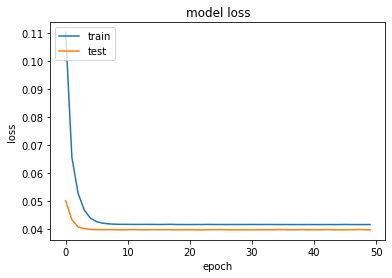

In [39]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
testpred = model.predict(xtest) # validate model on test data 
testpred = scaler.inverse_transform(testpred) # denormalized the data
testpred # show the test prediction result

array([[  19.605503,   54.05032 , 1013.4338  ,   73.123436,  454.37015 ],
       [  19.544867,   54.035976, 1013.43    ,   73.174835,  454.4228  ],
       [  19.52204 ,   54.032703, 1013.42944 ,   73.19404 ,  454.4431  ],
       ...,
       [  19.573385,   54.046165, 1013.4328  ,   73.14849 ,  454.39813 ],
       [  19.515844,   54.034958, 1013.4299  ,   73.1944  ,  454.44733 ],
       [  19.518229,   54.02764 , 1013.4281  ,   73.20049 ,  454.44678 ]],
      dtype=float32)

In [35]:
xtest[0] # for one row 

array([[0.66260623],
       [0.87025496],
       [0.61048159],
       [0.61388102],
       [0.7158363 ],
       [0.93576512],
       [0.66120996],
       [0.80836299],
       [0.4976491 ],
       [0.54120267],
       [0.57634249],
       [0.34174709],
       [0.61367292],
       [0.43619303],
       [0.57131367],
       [0.84463807],
       [0.25006623],
       [0.18781457],
       [0.37231788],
       [0.15880795]])

In [36]:
test_one_row = np.expand_dims(xtest[0], axis=0) #  add dummy dimension

In [37]:
testpred_row = model.predict(test_one_row) # test with one row 
testpred_row = scaler.inverse_transform(testpred_row) # denormalized the prediction
testpred_row # show the result

array([[  19.999857,   54.195488, 1013.5173  ,   71.99283 ,  454.79355 ]],
      dtype=float32)